In [1]:
# Transforming the ALFRED dataset
from utils import *

ALFRED_JSON_PATTERN = '../datasets/alfred/data/ALFRED_json_2.1.0/valid_unseen/*/*/*.json' 
train_dataset = load_next_alfred_data(ALFRED_JSON_PATTERN)
print('train dataset size: ', len(train_dataset))
print('%3f kb' % (sys.getsizeof(train_dataset) / 1024.0))

# Check if backup, pickled, langauge object exists
lang = Language()
if os.path.isfile('instruction_language.json'):
    lang.load('instruction_language.json')
    lang.reset_counts()

action_lang = Language()
if os.path.isfile('action_language.json'):
    action_lang.load('action_language.json')
    action_lang.reset_counts()

argument_lang = Language()
if os.path.isfile('argument_language.json'):
    argument_lang.load('argument_language.json')
    argument_lang.reset_counts()

print(action_lang.word2index)

100%|██████████| 255/255 [00:03<00:00, 84.24it/s]

train dataset size:  255
2.171875 kb
{'<SOS>': 0, '<EOS>': 1, 'GotoLocation': 2, 'PickupObject': 3, 'ToggleObject': 4, 'PutObject': 5, 'SliceObject': 6, 'CleanObject': 7, 'CoolObject': 8, 'HeatObject': 9}


# Instruction Dot Test With RNN Instruction Encoder-Decoder

In [5]:
from models import *

torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using: ',device)

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_predictor = ActionPredictor(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)
argument_decoder = AttnDecoderRNN(hidden_size, argument_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt', map_location=torch.device('cpu')))
if os.path.isfile('action_predictor.pt'):
    action_predictor.load_state_dict(torch.load('action_predictor.pt', map_location=torch.device('cpu')))
if os.path.isfile('argument_decoder.pt'):
    argument_decoder.load_state_dict(torch.load('argument_decoder.pt', map_location=torch.device('cpu')))

def predict(encoder, action_predictor, argument_decoder, sentence, encoder_lang, action_lang, argument_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(encoder_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        # Action predictor
        predictor_output = action_predictor(encoder_hidden.flatten())
        topv, topi = predictor_output.topk(1)
        predicted_action = action_lang.word(topi.item())
        
        # Argument Decoder
        decoder_input = torch.tensor([[encoder_lang.index('<SOS>')]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = argument_decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == encoder_lang.index('<EOS>'):
                #decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(argument_lang.word(topi.item()))

            decoder_input = topi.squeeze().detach()
        
        sfid = [normalize_action_name(predicted_action)] # Slot-Filling, Intent Detection
        sfid.extend(decoded_words)
        return sfid

predict(encoder, action_predictor, argument_decoder, ['grab', 'the', 'canteen', 'off', 'of', 'the', 'desk'], lang, action_lang, argument_lang)

Using:  cpu


['pick', 'vase']

In [6]:
# import ai2thor
import ai2thor.controller
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import torchtext

import pandas as pd
import json, pickle, time
from tqdm.notebook import trange, tqdm

print(ai2thor.__version__)
# word_vec = torchtext.vocab.FastText()
# controller = ai2thor.controller.Controller(scene='FloorPlan29', grid_size=0.25, visibilityDistance=0.75, quality='Very Low', headless=False)   
controller = ai2thor.controller.Controller('Very Low', False, True) #dict(scene='FloorPlan25', grid_size=0.25, visibilityDistance=0.75)) #, quality='Very Low', headless=True))
controller.start()
controller.step(dict(action='Initialize', grid_size=0.25, headless=True, visibilityDistance=0.75))
event = controller.step(dict(action='Pass'))
controller.reset('FloorPlan25')

#%run scene_graph.ipynb
#%run thorEnvironment.ipynb
from thor_environment import *

import os
import random
import networkx as nx
import matplotlib.pyplot as plt
import copy

from utils import *

# Seed for reproduceability
np.random.seed(42)

# Experiment parameters
debug_instructions = False
debug_scores = False
debug_log = True
subset = train_dataset[:] # DEBUG POINT
model = CosineModel().to(device)

# The test is for a multiple instructions intended to be executed over multiple timesteps of length 1
max_timesteps = 1 # TODO: Consider increasing to increase performance, niko used 10 i think.
reward = []
used_timesteps = []
trajectory_success = []
instruction_success = []
task_number = 0

# Experiment Log
if debug_log:
    debug_log_file = open('[BI-R] baseline_debug_log.tsv', 'w')
    debug_log_file.write("scene \t instruction \t expected_object \t expected_affordance \t actual_object \t actual_affordance \t success\n")

# run for each instruction in a task
for task in subset:
    trajectories, scene = task
    
    scene_name = "FloorPlan%d" % scene['scene_num']
    task_id = scene['task_id']
    object_poses = scene['object_poses']
    object_toggles = scene['object_toggles']
    dirty_and_empty = scene['dirty_and_empty']
    init_action = scene['init_action']
    
    # ALFRED has a custom initialised scene for each task
    # This is expensive, every task requires new initalisations and therefore new explorations
    environment_file = "../saved_environments/{}_{}.gz".format(scene_name, task_id)
    
    episode = {'log_probs':[], 'rewards':[], 'timesteps':0, 'entropy':[]}
    done = False
    t = 0
    task_number += 1
    print(" --- %d / %d --- %s" % (task_number, len(subset), task_id))
    
    for traj_idx, traj in enumerate(trajectories):
        # Each trajectory in a task uses the same environment but must be reset
        # each trajectory.
        controller.reset(scene_name)
        env = ThorEnvironment(controller=controller)
        
        if os.path.isfile(environment_file):
            # load file, if exists
            thor_restore(controller, init_action, object_poses, object_toggles, dirty_and_empty)
            print('Loading environment...')
            env.graph = env.graph.from_pickle(environment_file)
            if not hasattr(env.graph, 'robot_node'):
                env.graph.setup()
            print('Done')
        else:
            # explore and save
            thor_restore(controller, init_action, object_poses, object_toggles, dirty_and_empty)
            print('Exploring environment...')
            env.explore_environment()
            env.graph.setup()
            print('Saving environment...')
            env.graph.to_pickle(environment_file)
            print('Done')
        
        complete_trajectory = True
        
        if not valid_trajectory(env, traj):
            print('[CHECK] Invalid trajectory. Skipping...')
            continue
        else:
            print('[CHECK] Valid Trajectory!')
        
        if debug_instructions:
            print("Task Trajectory: %d / %d (%d instructions)" % (traj_idx+1, len(trajectories), len(traj['instructions'])))
            print('High level objective: %s | Task Num: %s' % (traj['task_desc'], task_id))
        
        for inst_idx, instruction in enumerate(traj['instructions']):
            if debug_instructions:
                print('-----> Instruction %d / %d' % (inst_idx + 1, len(traj['instructions'])))            
            
            target_object = instruction['argument_1']
            if not instruction['argument_2'] == '<unk>': # ALFRED PutObject actions receptical as argument_2. 
                target_object = instruction['argument_2']
            
            target_affordance = instruction['action']
            
            if debug_instructions:
                print("Target affordance: %s -> %s\nTarget Instruction: %s" % (instruction['action'], target_object, ' '.join(instruction['instruction'])))
            
            # Slot-Filling and Intent detection on the instruction
            predicted_sfid = predict(encoder, action_predictor, argument_decoder, instruction['instruction'][:MAX_LENGTH-1], lang, action_lang, argument_lang)
            target_embedding = [env.graph.word2vec(word.lower()) for word in predicted_sfid]
            
            #done = False
            for timestep in range(max_timesteps):
                
                env.graph.to_torch_graph()

                # Experimental, adds the object features to the affordances
                object_smooth_graph = add_object_features(env.graph)

                # run the policy network
                target = torch.tensor(target_embedding, dtype=torch.float).to(device)
                logits, max_affordances = model(object_smooth_graph, target)
                
                # we only care about the affordance nodes, so set the logits of all other nodes to something very small
                mask = torch.tensor(env.graph._torch_affordance_mask==0, dtype=torch.bool).to(device)
                logits[mask] = -1000
                
                # Debug model scores
                if debug_scores:
                    node_names = []
                    for n in max_affordances:
                        if env.graph.nodes[n.item()]['node_type'] == 'affordance':
                            node_names.append(env.graph.nodes[n.item()]['affordance'])
                        elif env.graph.nodes[n.item()]['node_type'] == 'object':
                            node_names.append(env.graph.nodes[n.item()]['obj'])
                    graph_word_scores([word.lower() for word in instruction['instruction']], node_names)
                
                
                # sample an action from the output of the model
                action = torch.argmax(logits)
                affordance = env.graph.from_torch_id(action.item())
                
                correct_affordance = False
                actual_affordance = env.graph.nodes[affordance]['affordance']
                                
                if actual_affordance == normalize_action_name(target_affordance):
                    correct_affordance = True
                
                r = 0.0
                succ, pred = env.graph.get_related_objects(affordance)
                
                correct_object = False
                actual_object = None
                
                if not pred is None:
                    for n in pred:
                        actual_object = env.graph.nodes[n]['obj']
                        if actual_object == target_object:
                            if correct_affordance:
                                r = 1.0
                                #done = True
                                correct_object = True
                                env.step(action.item()) # An Action is an affordance in the graph
                                # TODO: If action cannot be executed, break loop and print error. 
                                break
                
                print("Target: %s -> %s \t Actual: %s -> %s [%s]" % (normalize_action_name(target_affordance), target_object, actual_affordance, actual_object, correct_affordance and correct_object))
                
                if correct_affordance and correct_object:
                    instruction_success.append((1.0, normalize_action_name(target_affordance), len(target_embedding)))
                else:
                    complete_trajectory = False
                    instruction_success.append((0.0, normalize_action_name(target_affordance), len(target_embedding)))
                
                if debug_log:
                    debug_log_file.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (scene_name, ' '.join(instruction['instruction']), normalize_action_name(target_affordance), target_object, actual_affordance, actual_object, correct_object and correct_affordance))
                
                episode['rewards'].append(r)
                episode['timesteps'] = t
        
        if complete_trajectory:
            trajectory_success.append(1.0)
        else:
            trajectory_success.append(0.0)
    
    # === end of an episode ===
    used_timesteps.append(t)
    
    reward.append(np.sum(episode['rewards']))

if debug_log:
    debug_log_file.close()

2.1.0
 --- 1 / 255 --- trial_T20190908_145356_918528
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> garbagecan 	 Actual: go -> drawer [False]
PickupObject False Apple|-00.87|+00.23|+00.61 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Target: go -> microwave 	 Actual: go -> microwave [True]
Target: heat -> apple 	 Actual: go -> potato [False]
Target: go -> garbagecan 	 Actual: go -> papertowelroll [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> garbagecan 	 Actual: put -> garbagecan [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> garbagecan 	 Actual: go -> countertop [False]
PickupObject False Apple|-00.87|+00.23|+00.61 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: go -> papertowelroll [False]
Target: heat -> apple 	 Actual: go -> apple [False]
Target: go -> garbagecan 	 Actual: go -> countertop [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> garbagecan 	 Actual: put -> garbagecan [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> garbagecan 	 Actual: go -> shelf [False]
PickupObject False Apple|-00.87|+00.23|+00.

! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: go -> countertop [False]
Target: pick -> egg 	 Actual: pick -> potato [False]
Target: go -> fridge 	 Actual: go -> countertop [False]
Target: cool -> egg 	 Actual: go -> potato [False]
Target: go -> sinkbasin 	 Actual: go -> countertop [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
 --- 7 / 255 --- trial_T20190909_103610_740356
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sofa 	 Actual: go -> sofa [True]
PickupObject False CreditCard|-00.11|+00.07|+01.19 is not visible.
Target: pick -> creditcard 	 Actual: pick -> creditcard [True]
Target: go -> floorlamp 	 Actual: go -> shelf [False]
ToggleObjectOn False object not found: FloorLamp|-05.60|+00.00|+04.64S

Target: put -> cabinet 	 Actual: put -> handtowelholder [False]
 --- 12 / 255 --- trial_T20190908_214926_337906
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> soapbar 	 Actual: pick -> toiletpaper [False]
Target: go -> sinkbasin 	 Actual: put -> countertop [False]
Target: clean -> soapbar 	 Actual: put -> sinkbasin [False]
Target: go -> cabinet 	 Actual: go -> showerglass [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> cabinet 	 Actual: put -> cabinet [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False SoapBar|-00.14|+00.95|+02.77 is not visible.
Target: pick -> soapbar 	 Actual: pick -> soapbar [True]
Target: go -> sinkbasin 	 Actual: put -> countertop [False]
Target: clean -> soapbar 	 Actual: put -> sinkbasin [False]
Target: go -> cabinet 	 Actual: go -> showerglass [F

[CHECK] Valid Trajectory!
Target: go -> microwave 	 Actual: go -> fridge [False]
Target: pick -> cup 	 Actual: go -> cup [False]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: put -> cup 	 Actual: put -> cabinet [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> microwave 	 Actual: go -> drawer [False]
PickupObject False Cup|+01.00|+01.79|-01.34 is not visible.
Target: pick -> cup 	 Actual: pick -> cup [True]
Target: go -> sinkbasin 	 Actual: go -> countertop [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: put -> cup 	 Actual: put -> sinkbasin [False]
Loading environment...
Done
[CHECK] Valid Tra

PickupObject False CD|-00.90|+00.86|-00.84 is not visible.
Target: pick -> cd 	 Actual: pick -> cd [True]
Target: go -> safe 	 Actual: go -> safe [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> safe 	 Actual: put -> safe [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> desk 	 Actual: go -> shelf [False]
PickupObject False CD|-00.90|+00.86|-00.84 is not visible.
Target: pick -> cd 	 Actual: pick -> cd [True]
Target: go -> safe 	 Actual: go -> shelf [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> safe 	 Actual: put -> safe [True]
Target: go -> desk 	 Actual: go -> drawer [False]
PickupObject False CD|-00.90|+00.86|-00.84 is not visible.
Target: pick -> cd 	 Actual: pick -> cd [True]
Target: go -> safe 	 Actual: go -> drawer [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> safe 	 Actual: put -> safe [True]
 --- 21 / 255 

[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> drawer [False]
PickupObject False Knife|-00.62|+00.96|-01.39 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [True]
Target: go -> apple 	 Actual: go -> countertop [False]
SliceObject False object not found: Apple|+00.69|+00.96|+00.14
Target: slice -> apple 	 Actual: slice -> apple [True]
Target: go -> garbagecan 	 Actual: go -> countertop [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> garbagecan 	 Actual: put -> garbagecan [True]
Target: go -> countertop 	 Actual: go -> fridge [False]
PickupObject False Apple|+00.69|+00.96|+00.14 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: go -> countertop [False]
Target: heat -> apple 	 Actual: pick -> apple [False]
Target: go -> garbagecan 	 Actual: go -> fridge [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> garbag

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> shelf [True]
PickupObject False Statue|-00.22|+00.60|+01.19 is not visible.
Target: pick -> statue 	 Actual: pick -> statue [True]
Target: go -> floorlamp 	 Actual: go -> shelf [False]
ToggleObjectOn False object not found: FloorLamp|-05.60|+00.00|+04.64System.Reflection.TargetInvocationException: Exception has been thrown by the target of an invocation. ---> System.NullReferenceException: Object reference not set to an instance of an object
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.SimObjPhysics target, Boolean toggleOn, Boolean forceAction) [0x00000] in <filename unknown>:0 
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.ServerAction action, Boolean toggleOn, Boolean forceAction) [0x00000] in <filename unknown>:0 
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.Tog

Target: go -> coffeemachine 	 Actual: go -> cabinet [False]
Target: put -> coffeemachine 	 Actual: put -> mug [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Mug|+00.94|+00.91|-01.79 is not visible.
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: cool -> mug 	 Actual: put -> mug [False]
Target: go -> coffeemachine 	 Actual: go -> shelf [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> coffeemachine 	 Actual: put -> coffeemachine [True]
 --- 31 / 255 --- trial_T20190909_061130_844814
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> fridge [False]
PickupObject False Bowl|-01.10|+00.94|-01.43 is not visible.
Target: pick -> bowl 	 Actual: pick -> bowl [True]
Target: go -> sinkbasin 	 Actual: go -> countertop [False]
Target: clean -> bowl 	 Actual: 

Target: go -> countertop 	 Actual: go -> shelf [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
PickupObject False Knife|-01.17|+00.96|-00.12 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [True]
SliceObject False object not found: Bread|+01.03|+00.99|+00.14
Target: slice -> bread 	 Actual: slice -> bread [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
PickupObject False Bread|+01.03|+00.99|+00.14 is not visible.
Target: pick -> bread 	 Actual: pick -> bread [True]
Target: go -> microwave 	 Actual: go -> tomato [False]
Target: heat -> bread 	 Actual: go -> bread [False]
Target: go -> countertop 	 Actual: go -> drawer [False]
Target: put -> countertop 	 Actual: go -> bread [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [T

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> toilet 	 Actual: go -> showerglass [False]
Target: pick -> soapbar 	 Actual: pick -> toiletpaper [False]
Target: go -> garbagecan 	 Actual: go -> toiletpaperhanger [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> garbagecan 	 Actual: put -> garbagecan [True]
Target: go -> toilet 	 Actual: go -> cabinet [False]
Target: pick -> soapbar 	 Actual: pick -> soapbottle [False]
Target: go -> garbagecan 	 Actual: go -> showerglass [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> garbagecan 	 Actual: put -> garbagecan [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> toilet 	 Actual: go -> toilet [True]
PickupObject False SoapBar|-00.13|+00.95|+01.67 is not visible.
Target: pick -> soapbar 	 Actual: pick -> soapbar [True]
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
! Error when executing PUT aff

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> lettuce 	 Actual: go -> fridge [False]
Target: slice -> lettuce 	 Actual: put -> fridge [False]
Target: go -> fridge 	 Actual: go -> shelf [False]
Target: put -> fridge 	 Actual: go -> fridge [False]
Target: go -> fridge 	 Actual: slice -> lettuce [False]
PickupObject False Lettuce|+01.03|+01.21|+01.16 is not visible.
Target: pick -> lettuce 	 Actual: pick -> lettuce [True]
Target: go -> sinkbasin 	 Actual: go -> countertop [False]
Target: clean -> lettuce 	 Actual: slice -> lettuce [False]
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> garbagecan 	 Actual: put -> garbagecan [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObje

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> desk [False]
PickupObject False Mug|-02.05|+01.35|+00.33 is not visible.
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> desklamp 	 Actual: go -> shelf [False]
Target: toggle -> desklamp 	 Actual: go -> desklamp [False]
 --- 44 / 255 --- trial_T20190908_201444_037645
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> desk 	 Actual: go -> bed [False]
PickupObject False Mug|-00.82|+00.86|-01.18 is not visible.
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> desklamp 	 Actual: go -> desk [False]
Target: toggle -> desklamp 	 Actual: go -> desklamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> desk 	 Actual: go -> drawer [False]
PickupObject False Mug|-00.82|+00.86|-01.18 is not visible.
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> desklamp 	 Actual: go -> shelf [False]
Target: toggle -> desklamp 	 Actual: go

Target: go -> garbagecan 	 Actual: go -> fridge [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> garbagecan 	 Actual: put -> garbagecan [True]
 --- 50 / 255 --- trial_T20190908_225359_617900
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Tomato|-01.29|+00.97|-00.91 is not visible.
Target: pick -> tomato 	 Actual: pick -> tomato [True]
Target: go -> microwave 	 Actual: go -> drawer [False]
Target: heat -> tomato 	 Actual: put -> microwave [False]
Target: go -> garbagecan 	 Actual: go -> papertowelroll [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> garbagecan 	 Actual: put -> garbagecan [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Tomato|-01.29|+00.97|-00.91 is not visible.
Target: pick -> tomato 	 Actual: pick -> t

Target: go -> fridge 	 Actual: go -> fridge [True]
Target: cool -> bread 	 Actual: go -> bread [False]
Target: go -> countertop 	 Actual: go -> countertop [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
 --- 55 / 255 --- trial_T20190908_100512_362932
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cloth 	 Actual: go -> countertop [False]
PickupObject False Cloth|-00.35|+00.95|+02.07 is not visible.
Target: pick -> cloth 	 Actual: pick -> cloth [True]
Target: go -> sinkbasin 	 Actual: go -> countertop [False]
Target: clean -> cloth 	 Actual: pick -> cloth [False]
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: put -> countertop 	 Actual: put -> handtowelholder [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cloth 	 Actual: go -> countertop [False]
Target: pick -> cloth 	 Actual: pick -> toiletpaper [False]
Target: go -> sinkbasi

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> fridge [False]
PickupObject False ButterKnife|-00.55|+00.93|+00.16 is not visible.
Target: pick -> butterknife 	 Actual: pick -> butterknife [True]
Target: go -> cup 	 Actual: go -> papertowelroll [False]
Target: put -> cup 	 Actual: put -> drawer [False]
PickupObject False Cup|-01.57|+00.88|+02.77 is not visible.
Target: pick -> cup 	 Actual: pick -> cup [True]
Target: go -> countertop 	 Actual: go -> fridge [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> fridge [False]
PickupObject False ButterKnife|-00.55|+00.93|+00.16 is not visible.
Target: pick -> butterknife 	 Actual: pick -> butterknife [True]
Target: go -> cup 	 Actual: go -> countertop [False]
Target: put -> cup 	 Actual: put -> coffeemachine [Fa

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> fridge [False]
PickupObject False Potato|+00.69|+00.94|-00.56 is not visible.
Target: pick -> potato 	 Actual: pick -> potato [True]
Target: go -> microwave 	 Actual: go -> microwave [True]
Target: heat -> potato 	 Actual: go -> potato [False]
Target: go -> garbagecan 	 Actual: go -> fridge [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> garbagecan 	 Actual: put -> garbagecan [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> shelf [False]
PickupObject False Potato|+00.69|+00.94|-00.56 is not visible.
Target: pick -> potato 	 Actual: pick -> potato [True]
Target: go -> microwave 	 Actual: go -> drawer [False]
Target: heat -> potato 	 Actual: go -> potato [False]
Target: go -> garbagecan 	 Actual: go -> cabinet [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Tar

! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> stoveburner 	 Actual: go -> countertop [False]
Target: pick -> pan 	 Actual: pick -> pot [False]
Target: go -> sinkbasin 	 Actual: go -> countertop [False]
Target: clean -> pan 	 Actual: clean -> plate [False]
Target: go -> countertop 	 Actual: go -> cabinet [False]
Target: put -> countertop 	 Actual: put -> pot [False]
 --- 70 / 255 --- trial_T20190913_033141_859977
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: slice -> bread [False]
Target: pick -> bowl 	 Actual: pick -> statue [False]
Target: go -> countertop 	 Actual: go -> countertop [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
Target: pick -> egg 	 Actual: pick -> potato [False]
Target: put -> bo

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> pan 	 Actual: go -> countertop [False]
Target: put -> pan 	 Actual: put -> drawer [False]
Target: pick -> pan 	 Actual: pick -> pot [False]
Target: go -> sinkbasin 	 Actual: go -> countertop [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> shelf [False]
PickupObject False ButterKnife|-00.85|+00.93|+00.16 is not visible.
Target: pick -> butterknife 	 Actual: pick -> butterknife [True]
Target: go -> pan 	 Actual: go -> countertop [False]
Target: put -> pan 	 Actual: put -> drawer [False]
Target: pick -> pan 	 Actual: pick -> pot [False]
Target: go -> sinkbasin 	 Actual: go -> cabinet [False]
Target: put -> sinkbasin 	 Ac

[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> tomato 	 Actual: go -> drawer [False]
SliceObject False object not found: Tomato|+01.20|+00.95|-00.38
Target: slice -> tomato 	 Actual: slice -> tomato [True]
Target: go -> countertop 	 Actual: go -> drawer [False]
Target: put -> countertop 	 Actual: go -> knife [False]
Target: go -> countertop 	 Actual: go -> fridge [False]
PickupObject False Tomato|+01.20|+00.95|-00.38 is not visible.
Target: pick -> tomato 	 Actual: pick -> tomato [True]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: cool -> tomato 	 Actual: put -> fridge [False]
Target: go -> countertop 	 Actual: go -> shelf [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> count

Target: go -> countertop 	 Actual: go -> countertop [True]
Target: put -> countertop 	 Actual: go -> apple [False]
Target: go -> countertop 	 Actual: go -> drawer [False]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> apple 	 Actual: go -> drawer [False]
SliceObject False object not found: Apple|-01.01|+00.23|+00.54
Target: slice -> apple 	 Actual: slice -> apple [True]
Target: go -> apple 	 Actual: go -> sinkbasin [False]
SliceObject False object not found: Apple|-01.01|+00.23|+00.54
Target: slice -> apple 	 Actual: slice -> apple [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
PickupObject False Apple|-01.01|+00.23|+00.54 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: put -> countertop 	 Actual: go -> apple [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go 

Target: go -> countertop 	 Actual: go -> countertop [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
PickupObject False Knife|+00.94|+00.93|-00.21 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [True]
SliceObject False object not found: Apple|-00.75|+00.83|-00.75
Target: slice -> apple 	 Actual: slice -> apple [True]
Target: go -> apple 	 Actual: go -> countertop [False]
SliceObject False object not found: Apple|-00.75|+00.83|-00.75
Target: slice -> apple 	 Actual: slice -> apple [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
PickupObject False Apple|-00.75|+00.83|-00.75 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> countertop 	 Actual: go -> countertop [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> coun

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: go -> fridge [False]
PickupObject False SaltShaker|+01.21|+02.20|-00.97 is not visible.
Target: pick -> saltshaker 	 Actual: pick -> saltshaker [True]
Target: go -> drawer 	 Actual: go -> countertop [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> drawer 	 Actual: put -> drawer [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: go -> coffeemachine [False]
Target: pick -> saltshaker 	 Actual: put -> cabinet [False]
Target: go -> drawer 	 Actual: go -> cabinet [False]
Target: put -> drawer 	 Actual: go -> drawer [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: go -> drawer [False]
Target: pick -> saltshaker 	 Actual: pick -> spoon [False]
Target: go -> drawer 	 Actual: go -> fridge [False]
Target: put -> drawer 	 Actual: go -> drawer [False]
 --- 87 / 255 --- trial_T2019

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> armchair 	 Actual: go -> sofa [False]
PickupObject False RemoteControl|-02.09|+00.59|+04.38 is not visible.
Target: pick -> remotecontrol 	 Actual: pick -> remotecontrol [True]
Target: go -> floorlamp 	 Actual: go -> floorlamp [True]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> armchair 	 Actual: go -> armchair [True]
PickupObject False RemoteControl|-02.09|+00.59|+04.38 is not visible.
Target: pick -> remotecontrol 	 Actual: pick -> remotecontrol [True]
Target: go -> floorlamp 	 Actual: go -> sofa [False]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> armchair 	 Actual: go -> sidetable [False]
PickupObject False RemoteControl|-02.09|+00.59|+04.38 is not visible.
Target: pick -> remotecontrol 	 Actual: pick -> remotecontrol [True]
Target: go -> floorlamp

PickupObject False Plate|+01.10|+01.67|-02.17 is not visible.
Target: pick -> plate 	 Actual: pick -> plate [True]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
 --- 96 / 255 --- trial_T20190908_123311_648354
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> cabinet [False]
Target: pick -> glassbottle 	 Actual: pick -> vase [False]
Target: go -> plate 	 Actual: go -> cabinet [False]
Target: put -> plate 	 Actual: put -> cabinet [False]
PickupObject False Plate|+01.15|+01.67|+00.15 is not visible.
Target: pick -> plate 	 Actual: pick -> plate [True]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: put -> sinkbasin 	 Actual: put -> plate [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> drawer [False]
Target: pick -> glassbottle 	 Act

Target: go -> microwave 	 Actual: go -> papertowelroll [False]
Target: heat -> apple 	 Actual: pick -> apple [False]
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: put -> countertop 	 Actual: go -> apple [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> butterknife 	 Actual: pick -> butterknife [True]
Target: go -> apple 	 Actual: go -> drawer [False]
SliceObject False object not found: Apple|-01.01|+00.23|+00.61
Target: slice -> apple 	 Actual: slice -> apple [True]
PutObject False No valid positions to place object found
PutObject False No valid positions to place object found
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
PickupObject False 
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: go -> microwave [True]
Target: heat -> apple 	 Actual: pick -> apple [False]
Target: go -> countertop 	 Actual: toggle -> faucet [False]
PutO

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> bed 	 Actual: go -> window [False]
PickupObject False Book|+01.00|+00.78|+01.66 is not visible.
Target: pick -> book 	 Actual: pick -> book [True]
Target: go -> desklamp 	 Actual: go -> bed [False]
ToggleObjectOn False object not found: DeskLamp|-02.30|+00.87|+00.75System.Reflection.TargetInvocationException: Exception has been thrown by the target of an invocation. ---> System.NullReferenceException: Object reference not set to an instance of an object
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.SimObjPhysics target, Boolean toggleOn, Boolean forceAction) [0x00000] in <filename unknown>:0 
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.ServerAction action, Boolean toggleOn, Boolean forceAction) [0x00000] in <filename unknown>:0 
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObjectO

Target: go -> sinkbasin 	 Actual: go -> countertop [False]
Target: put -> sinkbasin 	 Actual: put -> drawer [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Fork|+00.83|+00.49|-00.61 is not visible.
Target: pick -> fork 	 Actual: pick -> fork [True]
Target: go -> cup 	 Actual: go -> cabinet [False]
Target: put -> cup 	 Actual: go -> fork [False]
Target: pick -> cup 	 Actual: pick -> papertowelroll [False]
Target: go -> sinkbasin 	 Actual: go -> cabinet [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> shelf [False]
PickupObject False Fork|+00.83|+00.49|-00.61 is not visible.
Target: pick -> fork 	 Actual: pick -> fork [True]
Target: go -> cup 	 Actual: go -> shelf [False]
Target: put -> cup 	 Actual: go -> fork [F

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Lettuce|+00.77|+00.99|-00.38 is not visible.
Target: pick -> lettuce 	 Actual: pick -> lettuce [True]
Target: go -> fridge 	 Actual: go -> papertowelroll [False]
Target: cool -> lettuce 	 Actual: go -> lettuce [False]
Target: go -> sinkbasin 	 Actual: go -> cabinet [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Lettuce|+00.77|+00.99|-00.38 is not visible.
Target: pick -> lettuce 	 Actual: pick -> lettuce [True]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: cool -> lettuce 	 Actual: put -> fridge [False]
Target: go -> sinkbasin 	 Actual: go -> cabinet [False]
! Error when executing PUT affordance: Agent does not carry an o

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: go -> cabinet [False]
PickupObject False Apple|-00.96|+00.23|+00.64 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: go -> microwave [True]
Target: heat -> apple 	 Actual: go -> apple [False]
Target: go -> fridge 	 Actual: go -> fridge [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> fridge 	 Actual: put -> fridge [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: go -> countertop [False]
PickupObject False Apple|-00.96|+00.23|+00.64 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: go -> drawer [False]
Target: heat -> apple 	 Actual: go -> apple [False]
Target: go -> fridge 	 Actual: go -> fridge [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> fridge 	 Actu

[CHECK] Valid Trajectory!
Target: go -> sidetable 	 Actual: go -> shelf [False]
PickupObject False CellPhone|-05.53|+01.04|+00.17 is not visible.
Target: pick -> cellphone 	 Actual: pick -> cellphone [True]
Target: go -> floorlamp 	 Actual: go -> dresser [False]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
 --- 116 / 255 --- trial_T20190908_044139_261907
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> armchair 	 Actual: go -> armchair [True]
Target: pick -> cellphone 	 Actual: pick -> cellphone [True]
Target: go -> floorlamp 	 Actual: go -> sidetable [False]
ToggleObjectOn False object not found: FloorLamp|-05.60|+00.00|+04.64System.Reflection.TargetInvocationException: Exception has been thrown by the target of an invocation. ---> System.NullReferenceException: Object reference not set to an instance of an object
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.SimObjPhysics target, Boolean toggleOn, Bo

Target: go -> fridge 	 Actual: go -> fridge [True]
Target: cool -> bread 	 Actual: put -> fridge [False]
Target: go -> microwave 	 Actual: go -> stoveknob [False]
Target: put -> microwave 	 Actual: go -> bread [False]
 --- 119 / 255 --- trial_T20190906_224631_058932
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Knife|-00.77|+00.96|-01.62 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [True]
SliceObject False object not found: Bread|+00.86|+00.99|-00.03
Target: slice -> bread 	 Actual: slice -> bread [True]
Target: go -> countertop 	 Actual: go -> drawer [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
Target: go -> countertop 	 Actual: go -> drawer [False]
PickupObject False Bread|+00.86|+00.99|-00.03 is not visible.
Target: pick -> bread 	 Actual: pick -> bread [True]
Target: go -> fridge 	 Ac

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> mug 	 Actual: pick -> papertowelroll [False]
Target: go -> sinkbasin 	 Actual: go -> fridge [False]
Target: clean -> mug 	 Actual: pick -> papertowelroll [False]
Target: go -> coffeemachine 	 Actual: go -> countertop [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> coffeemachine 	 Actual: put -> coffeemachine [True]
 --- 123 / 255 --- trial_T20190907_221208_560499
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: go -> drawer [False]
Target: pick -> mug 	 Actual: go -> cabinet [False]
Target: go -> sinkbasin 	 Actual: go -> fridge [False]
Target: clean -> mug 	 Actual: put -> sinkbasin [False]
Target: go -> coffeemachine 	 Actual: go -> shelf [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> coffeemachine 	 Actual: put -> coffeema

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> shelf [True]
PickupObject False Watch|-03.05|+01.00|+04.38 is not visible.
Target: pick -> watch 	 Actual: pick -> watch [True]
Target: go -> safe 	 Actual: go -> dresser [False]
Target: put -> safe 	 Actual: put -> drawer [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> shelf [True]
PickupObject False Watch|-03.05|+01.00|+04.38 is not visible.
Target: pick -> watch 	 Actual: pick -> watch [True]
Target: go -> safe 	 Actual: go -> sidetable [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> safe 	 Actual: put -> safe [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> shelf [True]
PickupObject False Watch|-03.05|+01.00|+04.38 is not visible.
Target: pick -> watch 	 Actual: pick -> watch [True]
Target: go -> safe 	 Actual: go -> safe [True]
! Error when executi

PickupObject False Cup|-01.47|+00.55|+02.87 is not visible.
Target: pick -> cup 	 Actual: pick -> cup [True]
Target: go -> countertop 	 Actual: go -> countertop [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
 --- 133 / 255 --- trial_T20190907_004351_281384
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> cabinet [False]
Target: pick -> soapbottle 	 Actual: pick -> candle [False]
Target: go -> toilet 	 Actual: go -> toilet [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> toilet 	 Actual: put -> toilet [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> soapbottle 	 Actual: pick -> candle [False]
Target: go -> toilet 	 Actual: go -> toilet [True]
Target: put -> toilet 	 Actual: put -> countertop [False]
Loading environme

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
PickupObject False Tomato|+00.69|+00.95|-02.05 is not visible.
Target: pick -> tomato 	 Actual: pick -> tomato [True]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
Target: pick -> knife 	 Actual: pick -> knife [True]
Target: slice -> tomato 	 Actual: put -> pan [False]
Target: put -> sinkbasin 	 Actual: go -> knife [False]
Target: pick -> tomato 	 Actual: heat -> pan [False]
Target: go -> microwave 	 Actual: clean -> cup [False]
Target: heat -> tomato 	 Actual: go -> pan [False]
Target: go -> sinkbasin 	 Actual: pick -> cup [False]
Target: put -> sinkbasin 	 Actual: pick -> pan [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Tomato|+00.69|+00.

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: go -> cabinet [True]
Target: pick -> cloth 	 Actual: pick -> toiletpaper [False]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: clean -> cloth 	 Actual: pick -> toiletpaper [False]
Target: go -> cabinet 	 Actual: go -> showerglass [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> cabinet 	 Actual: put -> cabinet [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: go -> cabinet [True]
Target: pick -> cloth 	 Actual: pick -> toiletpaper [False]
Target: go -> sinkbasin 	 Actual: go -> showerglass [False]
Target: clean -> cloth 	 Actual: put -> cabinet [False]
Target: go -> cabinet 	 Actual: go -> showerglass [False]
Target: put -> cabinet 	 Actual: put -> toilet [False]
 --- 142 / 255 --- trial_T20190908_220656_510400
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actua

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> desk 	 Actual: go -> garbagecan [False]
PickupObject False Pencil|-00.48|+00.86|-01.36 is not visible.
Target: pick -> pencil 	 Actual: pick -> pencil [True]
Target: go -> desklamp 	 Actual: go -> bed [False]
ToggleObjectOn False object not found: DeskLamp|-02.30|+00.87|+00.75System.Reflection.TargetInvocationException: Exception has been thrown by the target of an invocation. ---> System.NullReferenceException: Object reference not set to an instance of an object
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.SimObjPhysics target, Boolean toggleOn, Boolean forceAction) [0x00000] in <filename unknown>:0 
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.ServerAction action, Boolean toggleOn, Boolean forceAction) [0x00000] in <filename unknown>:0 
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.To

Target: go -> cabinet 	 Actual: go -> cabinet [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> cabinet 	 Actual: put -> cabinet [True]
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> soapbar 	 Actual: pick -> toiletpaper [False]
Target: go -> cabinet 	 Actual: go -> cabinet [True]
Target: put -> cabinet 	 Actual: put -> countertop [False]
 --- 148 / 255 --- trial_T20190906_203003_627271
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> toilet 	 Actual: go -> cabinet [False]
PickupObject False ToiletPaper|-00.28|+00.65|+01.99 is not visible.
Target: pick -> toiletpaper 	 Actual: pick -> toiletpaper [True]
Target: go -> cabinet 	 Actual: go -> countertop [False]
Target: put -> cabinet 	 Actual: put -> handtowelholder [False]
Target: go -> toiletpaperhanger 	 Actual: go -> toiletpaperhanger [True]
PickupObject False ToiletPaper|-00.28|+00.65|+01.99 is not visible.
Target: pick -> toiletpaper 	 Actu

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> basketball 	 Actual: go -> drawer [False]
PickupObject False BasketBall|+01.98|+00.12|+00.21 is not visible.
Target: pick -> basketball 	 Actual: pick -> basketball [True]
Target: go -> desklamp 	 Actual: go -> drawer [False]
Target: toggle -> desklamp 	 Actual: go -> desklamp [False]
 --- 152 / 255 --- trial_T20190907_161210_531813
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> basketball 	 Actual: go -> window [False]
PickupObject False BasketBall|+01.98|+00.12|+00.21 is not visible.
Target: pick -> basketball 	 Actual: pick -> basketball [True]
Target: go -> desklamp 	 Actual: go -> window [False]
Target: toggle -> desklamp 	 Actual: toggle -> desklamp [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> basketball 	 Actual: pick -> basketball [False]
PickupObject False BasketBall|+01.98|+00.12|+00.21 is not visible.
Target: pick -> basketball 	 Actual: pick -> basketball [

[CHECK] Valid Trajectory!
Target: go -> dresser 	 Actual: go -> dresser [True]
PickupObject False KeyChain|-02.30|+00.03|+00.37 is not visible.
Target: pick -> keychain 	 Actual: pick -> keychain [True]
Target: go -> box 	 Actual: go -> sofa [False]
Target: put -> box 	 Actual: put -> sofa [False]
PickupObject False Box|-00.95|+00.84|+02.75 is not visible.
Target: pick -> box 	 Actual: pick -> box [True]
Target: go -> armchair 	 Actual: go -> armchair [True]
Target: put -> armchair 	 Actual: put -> sidetable [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> dresser 	 Actual: go -> dresser [True]
PickupObject False KeyChain|-02.30|+00.03|+00.37 is not visible.
Target: pick -> keychain 	 Actual: pick -> keychain [True]
Target: go -> box 	 Actual: go -> cabinet [False]
Target: put -> box 	 Actual: put -> sofa [False]
PickupObject False Box|-00.95|+00.84|+02.75 is not visible.
Target: pick -> box 	 Actual: pick -> box [True]
Target: go -> armchair 	 Actual: go -> 

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> shelf [True]
PickupObject False Box|-00.31|+00.30|+01.10 is not visible.
Target: pick -> box 	 Actual: pick -> box [True]
Target: go -> floorlamp 	 Actual: go -> armchair [False]
ToggleObjectOn False object not found: FloorLamp|-05.60|+00.00|+04.64System.Reflection.TargetInvocationException: Exception has been thrown by the target of an invocation. ---> System.NullReferenceException: Object reference not set to an instance of an object
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.SimObjPhysics target, Boolean toggleOn, Boolean forceAction) [0x00000] in <filename unknown>:0 
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.ServerAction action, Boolean toggleOn, Boolean forceAction) [0x00000] in <filename unknown>:0 
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObj

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False SoapBar|-00.13|+00.95|+01.67 is not visible.
Target: pick -> soapbar 	 Actual: pick -> soapbar [True]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: clean -> soapbar 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: go -> countertop [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> showerglass [False]
Target: pick -> soapbar 	 Actual: pick -> toiletpaper [False]
Target: go -> sinkbasin 	 Actual: go -> cabinet [False]
Target: clean -> soapbar 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: go -> cabinet [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Act

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> desk 	 Actual: go -> bed [False]
PickupObject False Pencil|-00.82|+00.86|-00.66 is not visible.
Target: pick -> pencil 	 Actual: pick -> pencil [True]
Target: go -> shelf 	 Actual: go -> shelf [True]
Target: put -> shelf 	 Actual: put -> garbagecan [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> desk 	 Actual: go -> garbagecan [False]
PickupObject False Pencil|-00.82|+00.86|-00.66 is not visible.
Target: pick -> pencil 	 Actual: pick -> pencil [True]
Target: go -> shelf 	 Actual: go -> bed [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> shelf 	 Actual: put -> shelf [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> desk 	 Actual: go -> window [False]
Target: pick -> pencil 	 Actual: go -> shelf [False]
Target: go -> shelf 	 Actual: go -> bed [False]
Target: put -> shelf 	 Actual: put -> desk [False]
 --- 169 / 255 --- t

Target: go -> cabinet 	 Actual: go -> drawer [False]
Target: put -> cabinet 	 Actual: put -> microwave [False]
 --- 173 / 255 --- trial_T20190909_121559_082363
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: go -> drawer [False]
Target: pick -> mug 	 Actual: pick -> papertowelroll [False]
Target: go -> fridge 	 Actual: go -> countertop [False]
Target: cool -> mug 	 Actual: put -> mug [False]
Target: go -> cabinet 	 Actual: go -> countertop [False]
Target: put -> cabinet 	 Actual: go -> cabinet [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: go -> papertowelroll [False]
Target: pick -> mug 	 Actual: go -> cabinet [False]
Target: go -> fridge 	 Actual: go -> cabinet [False]
Target: cool -> mug 	 Actual: put -> fridge [False]
Target: go -> cabinet 	 Actual: go -> fridge [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> cabinet 	 Actual: put -> cabinet [True]
L

Target: go -> safe 	 Actual: put -> safe [False]
Target: put -> safe 	 Actual: put -> drawer [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sofa 	 Actual: go -> sidetable [False]
PickupObject False KeyChain|-03.86|+01.11|+04.79 is not visible.
Target: pick -> keychain 	 Actual: pick -> keychain [True]
Target: go -> safe 	 Actual: go -> safe [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> safe 	 Actual: put -> safe [True]
Target: go -> armchair 	 Actual: go -> armchair [True]
PickupObject False KeyChain|-03.86|+01.11|+04.79 is not visible.
Target: pick -> keychain 	 Actual: pick -> keychain [True]
Target: go -> safe 	 Actual: go -> sidetable [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> safe 	 Actual: put -> safe [True]
 --- 178 / 255 --- trial_T20190909_232711_494127
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> desk 	 Actual: go -> bed [

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> papertowelroll [False]
PickupObject False Spoon|-01.24|+00.92|-01.21 is not visible.
Target: pick -> spoon 	 Actual: pick -> spoon [True]
Target: go -> pan 	 Actual: go -> shelf [False]
Target: put -> pan 	 Actual: go -> spoon [False]
Target: pick -> pan 	 Actual: pick -> plate [False]
Target: go -> sinkbasin 	 Actual: go -> cabinet [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> fridge [False]
PickupObject False Spoon|-01.24|+00.92|-01.21 is not visible.
Target: pick -> spoon 	 Actual: pick -> spoon [True]
Target: go -> pan 	 Actual: go -> countertop [False]
Target: put -> pan 	 Actual: put -> drawer [False]
Target: pick -> pan 	 Actual: pick -> pot [False]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin 

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> sofa [False]
PickupObject False KeyChain|-01.00|+00.07|+00.26 is not visible.
Target: pick -> keychain 	 Actual: pick -> keychain [True]
Target: go -> floorlamp 	 Actual: go -> armchair [False]
ToggleObjectOn False object not found: FloorLamp|-05.60|+00.00|+04.64System.Reflection.TargetInvocationException: Exception has been thrown by the target of an invocation. ---> System.NullReferenceException: Object reference not set to an instance of an object
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.SimObjPhysics target, Boolean toggleOn, Boolean forceAction) [0x00000] in <filename unknown>:0 
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.ServerAction action, Boolean toggleOn, Boolean forceAction) [0x00000] in <filename unknown>:0 
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentContr

Target: go -> countertop 	 Actual: go -> countertop [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
 --- 191 / 255 --- trial_T20190908_114622_738670
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> stoveburner 	 Actual: go -> countertop [False]
Target: pick -> pan 	 Actual: pick -> pot [False]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: cool -> pan 	 Actual: pick -> pot [False]
Target: go -> countertop 	 Actual: go -> countertop [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> stoveburner 	 Actual: go -> drawer [False]
Target: pick -> pan 	 Actual: pick -> pot [False]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: cool -> pan 	 Actual: put -> pot [False]
Target: go -> countertop 	 Actual: g

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> shelf [True]
PickupObject False Vase|-01.28|+01.11|+00.27 is not visible.
Target: pick -> vase 	 Actual: pick -> vase [True]
Target: go -> safe 	 Actual: go -> safe [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> safe 	 Actual: put -> safe [True]
 --- 198 / 255 --- trial_T20190908_205204_244321
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> sidetable [False]
PickupObject False Vase|-00.21|+00.08|+00.83 is not visible.
Target: pick -> vase 	 Actual: pick -> vase [True]
Target: go -> safe 	 Actual: go -> safe [True]
Target: put -> safe 	 Actual: go -> vase [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> sidetable [False]
PickupObject False Vase|-00.21|+00.08|+00.83 is not visible.
Target: pick -> vase 	 Actual: pick -> vase [True]
Target: go -> safe 	 Actual: g

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sofa 	 Actual: go -> dresser [False]
PickupObject False Newspaper|-00.95|+00.62|+01.96 is not visible.
Target: pick -> newspaper 	 Actual: pick -> newspaper [True]
Target: go -> floorlamp 	 Actual: go -> sofa [False]
ToggleObjectOn False object not found: FloorLamp|-05.60|+00.00|+04.64System.Reflection.TargetInvocationException: Exception has been thrown by the target of an invocation. ---> System.NullReferenceException: Object reference not set to an instance of an object
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.SimObjPhysics target, Boolean toggleOn, Boolean forceAction) [0x00000] in <filename unknown>:0 
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.ServerAction action, Boolean toggleOn, Boolean forceAction) [0x00000] in <filename unknown>:0 
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentCont

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Potato|+00.94|+00.94|-01.88 is not visible.
Target: pick -> potato 	 Actual: pick -> potato [True]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: cool -> potato 	 Actual: put -> fridge [False]
Target: go -> microwave 	 Actual: go -> microwave [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> microwave 	 Actual: put -> microwave [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Potato|+00.94|+00.94|-01.88 is not visible.
Target: pick -> potato 	 Actual: pick -> potato [True]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: cool -> potato 	 Actual: go -> potato [False]
Target: go -> microwave 	 Actual: go -> sinkbasin [False]
Target: put -> microwave 	 Actual: go -> countertop [False]
Loading environment

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> baseballbat 	 Actual: go -> baseballbat [True]
PickupObject False BaseballBat|+01.95|+00.66|-01.81 is not visible.
Target: pick -> baseballbat 	 Actual: pick -> baseballbat [True]
Target: go -> desklamp 	 Actual: go -> bed [False]
Target: toggle -> desklamp 	 Actual: go -> desklamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> baseballbat 	 Actual: go -> baseballbat [True]
PickupObject False BaseballBat|+01.95|+00.66|-01.81 is not visible.
Target: pick -> baseballbat 	 Actual: pick -> baseballbat [True]
Target: go -> desklamp 	 Actual: go -> bed [False]
Target: toggle -> desklamp 	 Actual: go -> desklamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> baseballbat 	 Actual: go -> drawer [False]
Target: pick -> baseballbat 	 Actual: pick -> baseballbat [True]
Target: go -> desklamp 	 Actual: cool -> mug [False]
Target: toggle -> desklamp 	 Actual: go -> pillow [Fa

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> spoon 	 Actual: pick -> spoon [True]
Target: go -> mug 	 Actual: go -> faucet [False]
Target: put -> mug 	 Actual: go -> spoon [False]
Target: pick -> mug 	 Actual: pick -> pot [False]
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: put -> countertop 	 Actual: put -> cabinet [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> coffeemachine [False]
PickupObject False Spoon|+00.94|+00.91|-00.73 is not visible.
Target: pick -> spoon 	 Actual: pick -> spoon [True]
Target: go -> mug 	 Actual: go -> shelf [False]
Target: put -> mug 	 Actual: go -> spoon [False]
PickupObject False Mug|-01.47|+00.88|+02.72 is not visible.
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> countertop 	 Actual: go -> fridge [False]
Target: put -> countertop 	 Actual: put -> cabinet [False]
Loading environ

Target: pick -> knife 	 Actual: pick -> knife [True]
Target: go -> sinkbasin 	 Actual: go -> countertop [False]
Target: clean -> knife 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: go -> drawer [False]
Target: put -> countertop 	 Actual: go -> knife [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> drawer [False]
PickupObject False Knife|+01.03|+00.93|-00.21 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [True]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: clean -> knife 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: put -> countertop 	 Actual: go -> knife [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> garbagecan [False]
PickupObject False Knife|+01.03|+00.93|-00.21 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [True]
Target: go -> sinkbasin 	 Actual: 

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: go -> vase [False]
PickupObject False Apple|-00.64|+00.83|-00.57 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: go -> drawer [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: heat -> apple 	 Actual: heat -> apple [True]
Target: go -> sinkbasin 	 Actual: go -> drawer [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> sinkbasin 	 Actual: put -> sinkbasin [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: go -> countertop [False]
PickupObject False Apple|-00.64|+00.83|-00.57 is not visible.
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: go -> microwave [True]
Target: heat -> apple 	 Actual: pick -> apple [False]
Target: go -> sinkbasin 	 Actual: go -> sink [False]
! Error when exe

Target: go -> cabinet 	 Actual: go -> cabinet [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> cabinet 	 Actual: put -> cabinet [True]
 --- 228 / 255 --- trial_T20190907_083346_800823
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: go -> drawer [False]
Target: pick -> cup 	 Actual: pick -> vase [False]
Target: go -> microwave 	 Actual: go -> drawer [False]
Target: heat -> cup 	 Actual: pick -> mug [False]
Target: go -> cabinet 	 Actual: go -> shelf [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> cabinet 	 Actual: put -> cabinet [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: go -> shelf [False]
Target: pick -> cup 	 Actual: pick -> vase [False]
Target: go -> microwave 	 Actual: go -> stoveknob [False]
Target: heat -> cup 	 Actual: put -> cabinet [False]
Target: go -> cabinet 	 Actual: go -> countertop [False]


Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> cabinet [False]
Target: pick -> peppershaker 	 Actual: pick -> saltshaker [False]
Target: go -> drawer 	 Actual: go -> drawer [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> drawer 	 Actual: put -> drawer [True]
Target: go -> countertop 	 Actual: go -> drawer [False]
Target: pick -> peppershaker 	 Actual: pick -> saltshaker [False]
Target: go -> drawer 	 Actual: go -> countertop [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> drawer 	 Actual: put -> drawer [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> drawer [False]
Target: pick -> peppershaker 	 Actual: pick -> saltshaker [False]
Target: go -> drawer 	 Actual: go -> drawer [True]
Target: put -> drawer 	 Actual: go -> drawer [False]
Target: go -> countertop 	 Actual: go -> drawer [False]
Targ

Target: put -> microwave 	 Actual: go -> potato [False]
 --- 237 / 255 --- trial_T20190909_120632_691361
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> egg 	 Actual: pick -> potato [False]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: clean -> egg 	 Actual: pick -> potato [False]
Target: go -> microwave 	 Actual: go -> countertop [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> microwave 	 Actual: put -> microwave [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> egg 	 Actual: pick -> potato [False]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: clean -> egg 	 Actual: pick -> potato [False]
Target: go -> microwave 	 Actual: go -> drawer [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> micro

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> papertowelroll [False]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> potato 	 Actual: go -> coffeemachine [False]
SliceObject False object not found: Potato|+00.78|+01.17|+00.97
Target: slice -> potato 	 Actual: slice -> potato [True]
Target: go -> shelf 	 Actual: go -> shelf [True]
Target: put -> shelf 	 Actual: go -> knife [False]
Target: go -> fridge 	 Actual: go -> fridge [True]
PickupObject False Potato|+00.78|+01.17|+00.97 is not visible.
Target: pick -> potato 	 Actual: pick -> potato [True]
Target: go -> microwave 	 Actual: go -> countertop [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: heat -> potato 	 Actual: heat -> potato [True]
Target: go -> fridge 	 Actual: go -> papertowelroll [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> fridge 	 Actual: put -> fridge [True

SliceObject False object not found: Lettuce|+01.11|+00.99|+00.14
Target: slice -> lettuce 	 Actual: slice -> lettuce [True]
Target: go -> countertop 	 Actual: go -> countertop [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> countertop 	 Actual: put -> countertop [True]
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Lettuce|+01.11|+00.99|+00.14 is not visible.
Target: pick -> lettuce 	 Actual: pick -> lettuce [True]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: cool -> lettuce 	 Actual: put -> fridge [False]
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> garbagecan 	 Actual: put -> garbagecan [True]
 --- 245 / 255 --- trial_T20190909_213855_654145
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> knife 	 Actual: pick ->

Target: go -> desk 	 Actual: go -> bed [False]
Target: put -> desk 	 Actual: put -> mug [False]
 --- 249 / 255 --- trial_T20190909_203041_433487
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> desk [False]
PickupObject False Mug|-01.83|+01.72|+00.41 is not visible.
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> desk 	 Actual: go -> bed [False]
Target: put -> desk 	 Actual: put -> mug [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> bed [False]
PickupObject False Mug|-01.83|+01.72|+00.41 is not visible.
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> desk 	 Actual: go -> window [False]
Target: put -> desk 	 Actual: put -> mug [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> bed [False]
PickupObject False Mug|-01.83|+01.72|+00.41 is not visible.
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> desk 	 Actua

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> dresser 	 Actual: go -> dresser [True]
Target: pick -> laptop 	 Actual: pick -> laptop [True]
Target: go -> floorlamp 	 Actual: go -> sofa [False]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> dresser 	 Actual: go -> dresser [True]
Target: pick -> laptop 	 Actual: pick -> laptop [True]
TeleportFull False Cannot teleport due to hand object collision.
Target: go -> floorlamp 	 Actual: go -> floorlamp [True]
ToggleObjectOn False object not found: FloorLamp|-05.60|+00.00|+04.64System.Reflection.TargetInvocationException: Exception has been thrown by the target of an invocation. ---> System.NullReferenceException: Object reference not set to an instance of an object
  at UnityStandardAssets.Characters.FirstPerson.PhysicsRemoteFPSAgentController.ToggleObject (.SimObjPhysics target, Boolean toggleOn, Boolean forceAction) [0x00000] in <filename

[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> fridge [False]
PickupObject False Spatula|-00.70|+00.95|-01.62 is not visible.
Target: pick -> spatula 	 Actual: pick -> spatula [True]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: clean -> spatula 	 Actual: pick -> spatula [False]
Target: go -> drawer 	 Actual: go -> stoveknob [False]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> drawer 	 Actual: put -> drawer [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Spatula|-00.70|+00.95|-01.62 is not visible.
Target: pick -> spatula 	 Actual: pick -> spatula [True]
Target: go -> sinkbasin 	 Actual: go -> countertop [False]
Target: clean -> spatula 	 Actual: put -> cabinet [False]
Target: go -> drawer 	 Actual: go -> stoveknob [False]
Target: put -> drawer 	 Actual: go -> drawer [False]
 --- 254 / 255 --- trial_T20190907_08080

Visualise Baseline Performance
-----------------------------

Tasks:  255
Trajectories:  821
Instructions:  5140
Trajectory Successes:  17.0
Trajectory Failures:  804.0
Failure:  {'go': 1625.0, 'pick': 360.0, 'heat': 95.0, 'put': 339.0, 'cool': 109.0, 'toggle': 106.0, 'clean': 112.0, 'slice': 11.0}
Success:  {'go': 826.0, 'pick': 756.0, 'heat': 41.0, 'put': 598.0, 'cool': 0.0, 'toggle': 67.0, 'clean': 1.0, 'slice': 94.0}
go = 33.70%
pick = 67.74%
heat = 30.15%
put = 63.82%
cool = 0.00%
toggle = 38.73%
clean = 0.88%
slice = 89.52%
[[8.260e+02 7.560e+02 4.100e+01 5.980e+02 0.000e+00 6.700e+01 1.000e+00
  9.400e+01]
 [1.625e+03 3.600e+02 9.500e+01 3.390e+02 1.090e+02 1.060e+02 1.120e+02
  1.100e+01]]


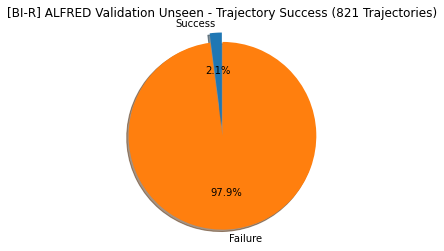

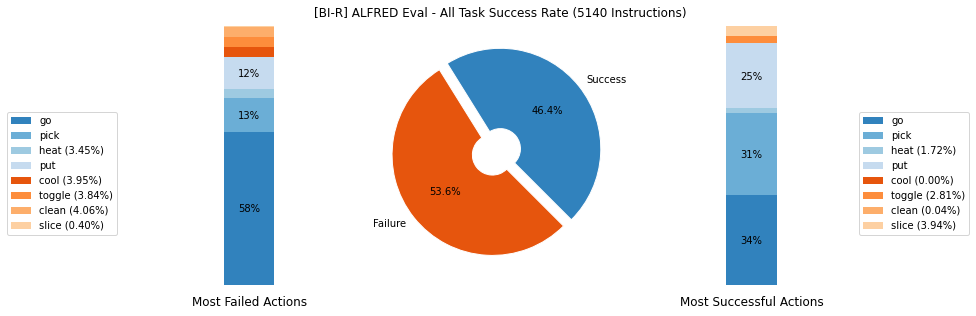

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

success = instruction_success

print("Tasks: ", len(subset))
print("Trajectories: ", len(trajectory_success))
print("Instructions: ", len(instruction_success))

succ_sum = 0
for i in success:
    succ_sum += i[0]

save_figures = True

# Trajectory pie chart
traj_success_count = sum(trajectory_success)
traj_fail_count = len(trajectory_success) - traj_success_count
print('Trajectory Successes: ', traj_success_count)
print('Trajectory Failures: ', traj_fail_count)
fig1, ax1 = plt.subplots()
ax1.pie([traj_success_count, traj_fail_count], explode=(0.0,0.1), labels=['Success','Failure'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title='[BI-R] ALFRED Validation Unseen - Trajectory Success (%d Trajectories)' % len(trajectory_success))
if save_figures:
    plt.savefig('[BI-R] ALFRED Validation Unseen - Trajectory Success.png', dpi=300, bbox_inches='tight')

# Instruction pie and bar chart
action_failure = {}
action_success = {}
task_instruction_lengths = {}

for i in success:
    if not i[1] in action_success:
        action_success[i[1]] = 0.0
    if not i[1] in action_failure:
        action_failure[i[1]] = 0.0
    if not i[1] in task_instruction_lengths:
        task_instruction_lengths[i[1]] = []
    if i[0] == 1.0:
        action_success[i[1]] += 1.0
    else:
        action_failure[i[1]] += 1.0
    task_instruction_lengths[i[1]].append(i[2])

action_list = list(action_success.keys())

print('Failure: ', action_failure)
print('Success: ', action_success)

for k, v in action_success.items():
    print(f"{k} = {(v / (action_failure[k]+v)) * 100.0:.2f}%")

# make figure and assign axis objects
fig = plt.figure(figsize=(9+4.5, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
fig.subplots_adjust(wspace=0)

size = 0.2
vals = np.array([list(action_success.values()), list(action_failure.values())])
print(vals)

cmap = plt.get_cmap("tab20c")
pie_colors = cmap(np.arange(3)*4)
bar_colors = cmap(np.arange(8))

# bar chart parameters
xpos = 0
bottom = 0
ratios = [i / np.sum(vals[1]) for i in vals[1]] #Failure values
width = .2
fail_labels = action_list[:]

for j in range(len(ratios)):
    height = ratios[j]
    ax1.bar(xpos, height, width, bottom=bottom, color=bar_colors[j], ecolor='w')
    ypos = bottom + ax1.patches[j].get_height() / 2.
    bottom += height
    if ratios[j] > 0.1:
        ax1.text(xpos, ypos - 0.015, "%d%%" % (ax1.patches[j].get_height() * 100),
                 ha='center')
    else:
        fail_labels[j] = "{} ({:.2f}%)".format(fail_labels[j], ratios[j] * 100.0)

ax1.set_title('Most Failed Actions', y=-0.1)
ax1.legend(fail_labels, bbox_to_anchor=(0,0.25), loc="lower left",  bbox_transform=fig.transFigure)
ax1.axis('off')
ax1.set_xlim(- 2.5 * width, 2.5 * width)

# pie chart parameters
ax2.pie(vals.sum(axis=1), explode=(0.0,0.1), labels=('Success', 'Failure'), autopct='%1.1f%%',
        shadow=False, startangle=-45, radius=1., colors=pie_colors, wedgeprops=dict(width=0.8, edgecolor='w'))

ax2.set(title='[BI-R] ALFRED Eval - All Task Success Rate (%d Instructions)' % len(success))

# bar chart parameters
xpos = 0
bottom = 0
ratios = [i / succ_sum for i in vals[0]] #Success values
width = .2

for j in range(len(ratios)):
    height = ratios[j]
    ax3.bar(xpos, height, width, bottom=bottom, color=bar_colors[j], ecolor='w')
    ypos = bottom + ax3.patches[j].get_height() / 2.
    bottom += height
    if ratios[j] > 0.05:
        ax3.text(xpos, ypos - 0.015, "%d%%" % (ax3.patches[j].get_height() * 100),
                 ha='center')
    else:
        action_list[j] = "{} ({:.2f}%)".format(action_list[j], ratios[j] * 100.0)

ax3.set_title('Most Successful Actions', y=-0.1)
ax3.legend(action_list, bbox_to_anchor=(1,0.25), loc="lower right",  bbox_transform=fig.transFigure)
ax3.axis('off')
ax3.set_xlim(- 2.5 * width, 2.5 * width)

#plt.tight_layout()
if save_figures:
    plt.savefig('[BI-R] ALFRED_Eval-instructions-success.png', dpi=300, bbox_inches='tight')

In [ ]:
# Instruction Length Bar Chart
# Instruction length vs task success
plt.rcdefaults()
fig, ax = plt.subplots()

action_success_sorted = dict(sorted(action_success.items(), key=lambda item: item[1], reverse=True))
task_lengths_sorted = {}
for k in action_success_sorted.keys():
    task_lengths_sorted[k] = np.mean(task_instruction_lengths[k])

tasks = action_success_sorted.keys() # In order of success
y_pos = np.arange(len(tasks))
tasks_success = task_lengths_sorted.values()

ax.barh(y_pos, tasks_success, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(tasks)
ax.invert_yaxis()  # labels read top-to-bottom
rects = ax.patches
labels = ["%.2f%%" % ((i/succ_sum)*100.0) for i in action_success_sorted.values()]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + 0.55, label,
            ha='center', va='bottom')
ax.set_xlabel('Average Instruction Length')
ax.set_title('Comparing instruction length to task success')
if save_figures:
    plt.savefig('Comparing instruction length to task success.png', dpi=300, bbox_inches='tight')

In [ ]:
import pandas as pd
import cv2
import pathlib

#=========================================================
#import torchtext

# Load FastText word vectors
#fast_text = torchtext.vocab.FastText(cache='../.vector_cache')

# Load ALFRED training data using torchtext
import torchtext.data as data

#  Basic english normalisation, lowers and seperates grammar
INSTRUCTION = data.Field(tokenize='basic_english', lower=True,
                         init_token='<sos>',
                         eos_token='<eos>',)
ACTION = data.Field(is_target=True)
ACTION_ARGUMENT_1 = data.Field(tokenize='basic_english',is_target=True)
ACTION_ARGUMENT_2 = data.Field(tokenize='basic_english',is_target=True)

ALFRED_DATA_ROOT = '../honours_research_repo/'
ALFRED_TRAIN_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Train_InstActionArgs.tsv'
ALFRED_VALIDATION_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Validation_InstActionArgs.tsv'
ALFRED_TEST_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Test_InstActionArgs.tsv'

def filter_action(example):
    if example.action[0] == 'PickupObject':
        return True
    else:
        return False

train, val, test = data.TabularDataset.splits(
    path='', 
    train=ALFRED_TRAIN_INSTRUCTION_TSV_FILENAME,
    validation=ALFRED_VALIDATION_INSTRUCTION_TSV_FILENAME,
    test=ALFRED_TEST_INSTRUCTION_TSV_FILENAME, format='tsv',
    fields=[('trajectory_number', None),
            ('task_description', None),
            ('instruction_number', None),
            ('instruction', INSTRUCTION),
            ('action', ACTION),
            ('action_argument_1', ACTION_ARGUMENT_1),
            ('action_argument_2', ACTION_ARGUMENT_2)
           ], 
    filter_pred=filter_action)

INSTRUCTION.build_vocab(train,vectors=__word_vec__) #'fasttext.en.300d')
ACTION.build_vocab(train)
ACTION_ARGUMENT_1.build_vocab(train,vectors=__word_vec__)
ACTION_ARGUMENT_2.build_vocab(train,vectors=__word_vec__)
#=========================================================